In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.impute import KNNImputer
import networkx as nx
from textblob import TextBlob
from networkx.algorithms import bipartite
import nltk
from nltk import sent_tokenize, wordnet, word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import conll2000, stopwords
from nltk.stem import WordNetLemmatizer 
from pandas import HDFStore, DataFrame
# import goslate
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.stem import PorterStemmer
from gensim.summarization import keywords, summarize
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

In [2]:
def clean(text):
    cleaned=[]
    tok=nltk.RegexpTokenizer(r'\w+').tokenize(text=text)
    for w in range(len(tok)):
        tok[w]=tok[w].lower()
        if tok[w] not in stopwords.words('english'):
            cleaned.append(WordNetLemmatizer().lemmatize(tok[w]))
    return(' '.join(cleaned))

# CREATE THE NETWORK

## Open comment file

In [3]:
#open comments from saved pkl
comments=pd.read_pickle("Comments_df.pkl")

apro il file dei commenti, in cui ogni riga è un commento fatto da un certo utente U ad un video V

In [3]:
#take a look
comments.head()

,user_channel_id,comment_text_display,comment_text_original,like_count,published_at,updatedt_at,video_id,comment_id
0,UCtjjtnZJm4j8A8guJ8kwMag,Share this video with your friends!,Share this video with your friends!,1,2020-02-06T07:48:31Z,2020-02-06T07:48:31Z,OpkZ2Zf7AXs,UgxMPULX4uVrF9J3oHd4AaABAg
1,UC4wFSFWiN1AZ26v5WaEulzQ,It&#39;s very informative and gives more knowl...,It's very informative and gives more knowledge...,0,2020-03-18T02:30:49Z,2020-03-18T02:30:49Z,tgNxJsvMvgs,UgzCC4SUG4nl1CqtklR4AaABAg
2,UCFRCkDluSpsZMnlc_4-tnCw,WHAT EVIDENCE OF THE ACCURACY OF THE PCR OR OT...,WHAT EVIDENCE OF THE ACCURACY OF THE PCR OR OT...,0,2020-03-29T21:41:03Z,2020-03-29T21:41:03Z,pac3UtZGgr8,Ugw8JmkPVeFz8E0kaiF4AaABAg
3,UCY45NPEzPr6GoX3iKJRG_SQ,Social distancing. Genius,Social distancing. Genius,0,2020-03-25T04:27:13Z,2020-03-25T04:27:13Z,lRvvBQefXm8,UgxY4LI_LkXbA9C1LtF4AaABAg
4,UCCHH-p7c7d2lCqogA3cYlLQ,Crazy how much its grown,Crazy how much its grown,0,2020-03-19T23:35:09Z,2020-03-19T23:35:09Z,wCR4g-32F6I,UgxMGSaV9OOjSUfM58Z4AaABAg


# Working on the graph

In [4]:
len(comments)

16100464

In [5]:
#controlla che non ci siano NAs
comments.isna().sum()

user_channel_id          0
comment_text_display     0
comment_text_original    0
like_count               0
published_at             0
updatedt_at              0
video_id                 0
comment_id               0
dtype: int64

## Apri grafi

In [3]:
#read graph and make them into Digraph
B1=nx.read_adjlist('B1.gz',  create_using=nx.DiGraph())
B=nx.read_adjlist('full_net.gz',  create_using=nx.DiGraph())

Vedo la distribuzione del grado (uscente) dei nodi (utenti)

In [4]:
#save outdegree of the nodes
degs=B.out_degree()

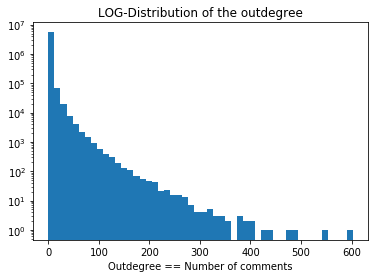

In [12]:
plt.hist(dict(degs).values(), bins=50, log=True)
plt.title('LOG-Distribution of the outdegree')
plt.xlabel('Outdegree == Number of comments')
plt.show()

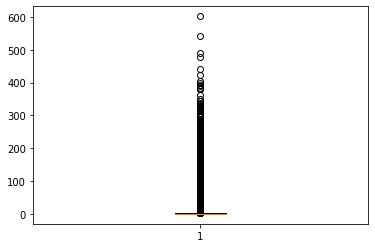

In [13]:
plt.boxplot(dict(degs).values())
plt.show()

In [14]:
threshold_commenters=np.percentile(list(dict(degs).values()), 99.99)
threshold_commenters

146.0

Tengo solo gli utenti della rete che sono oltre il 99.99esimo percentile

In [5]:
#select the nodes we want to study
keep=[x for x in B.nodes() if degs[x]>threshold_commenters]

Ridefinisco un nuovo grafo con solo questi utenti e i video che hanno commentato

In [6]:
queryDF=comments.loc[comments.user_channel_id.isin(keep)]

B1 = nx.DiGraph()
#add nodes of bipartite graph from users and videos
B1.add_nodes_from(queryDF['user_channel_id'], bipartite=0)
B1.add_nodes_from(queryDF['video_id'], bipartite=1)
#add edges
B1.add_edges_from([(row['user_channel_id'], row['video_id']) for idx, row in queryDF.iterrows()])
#set position for the plot
pos = {node:[0, i] for i,node in enumerate(queryDF['user_channel_id'])}
pos.update({node:[1, i] for i,node in enumerate(queryDF['video_id'])})

In [18]:
B1.order()

8433

C:\Users\giuli\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\giuli\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


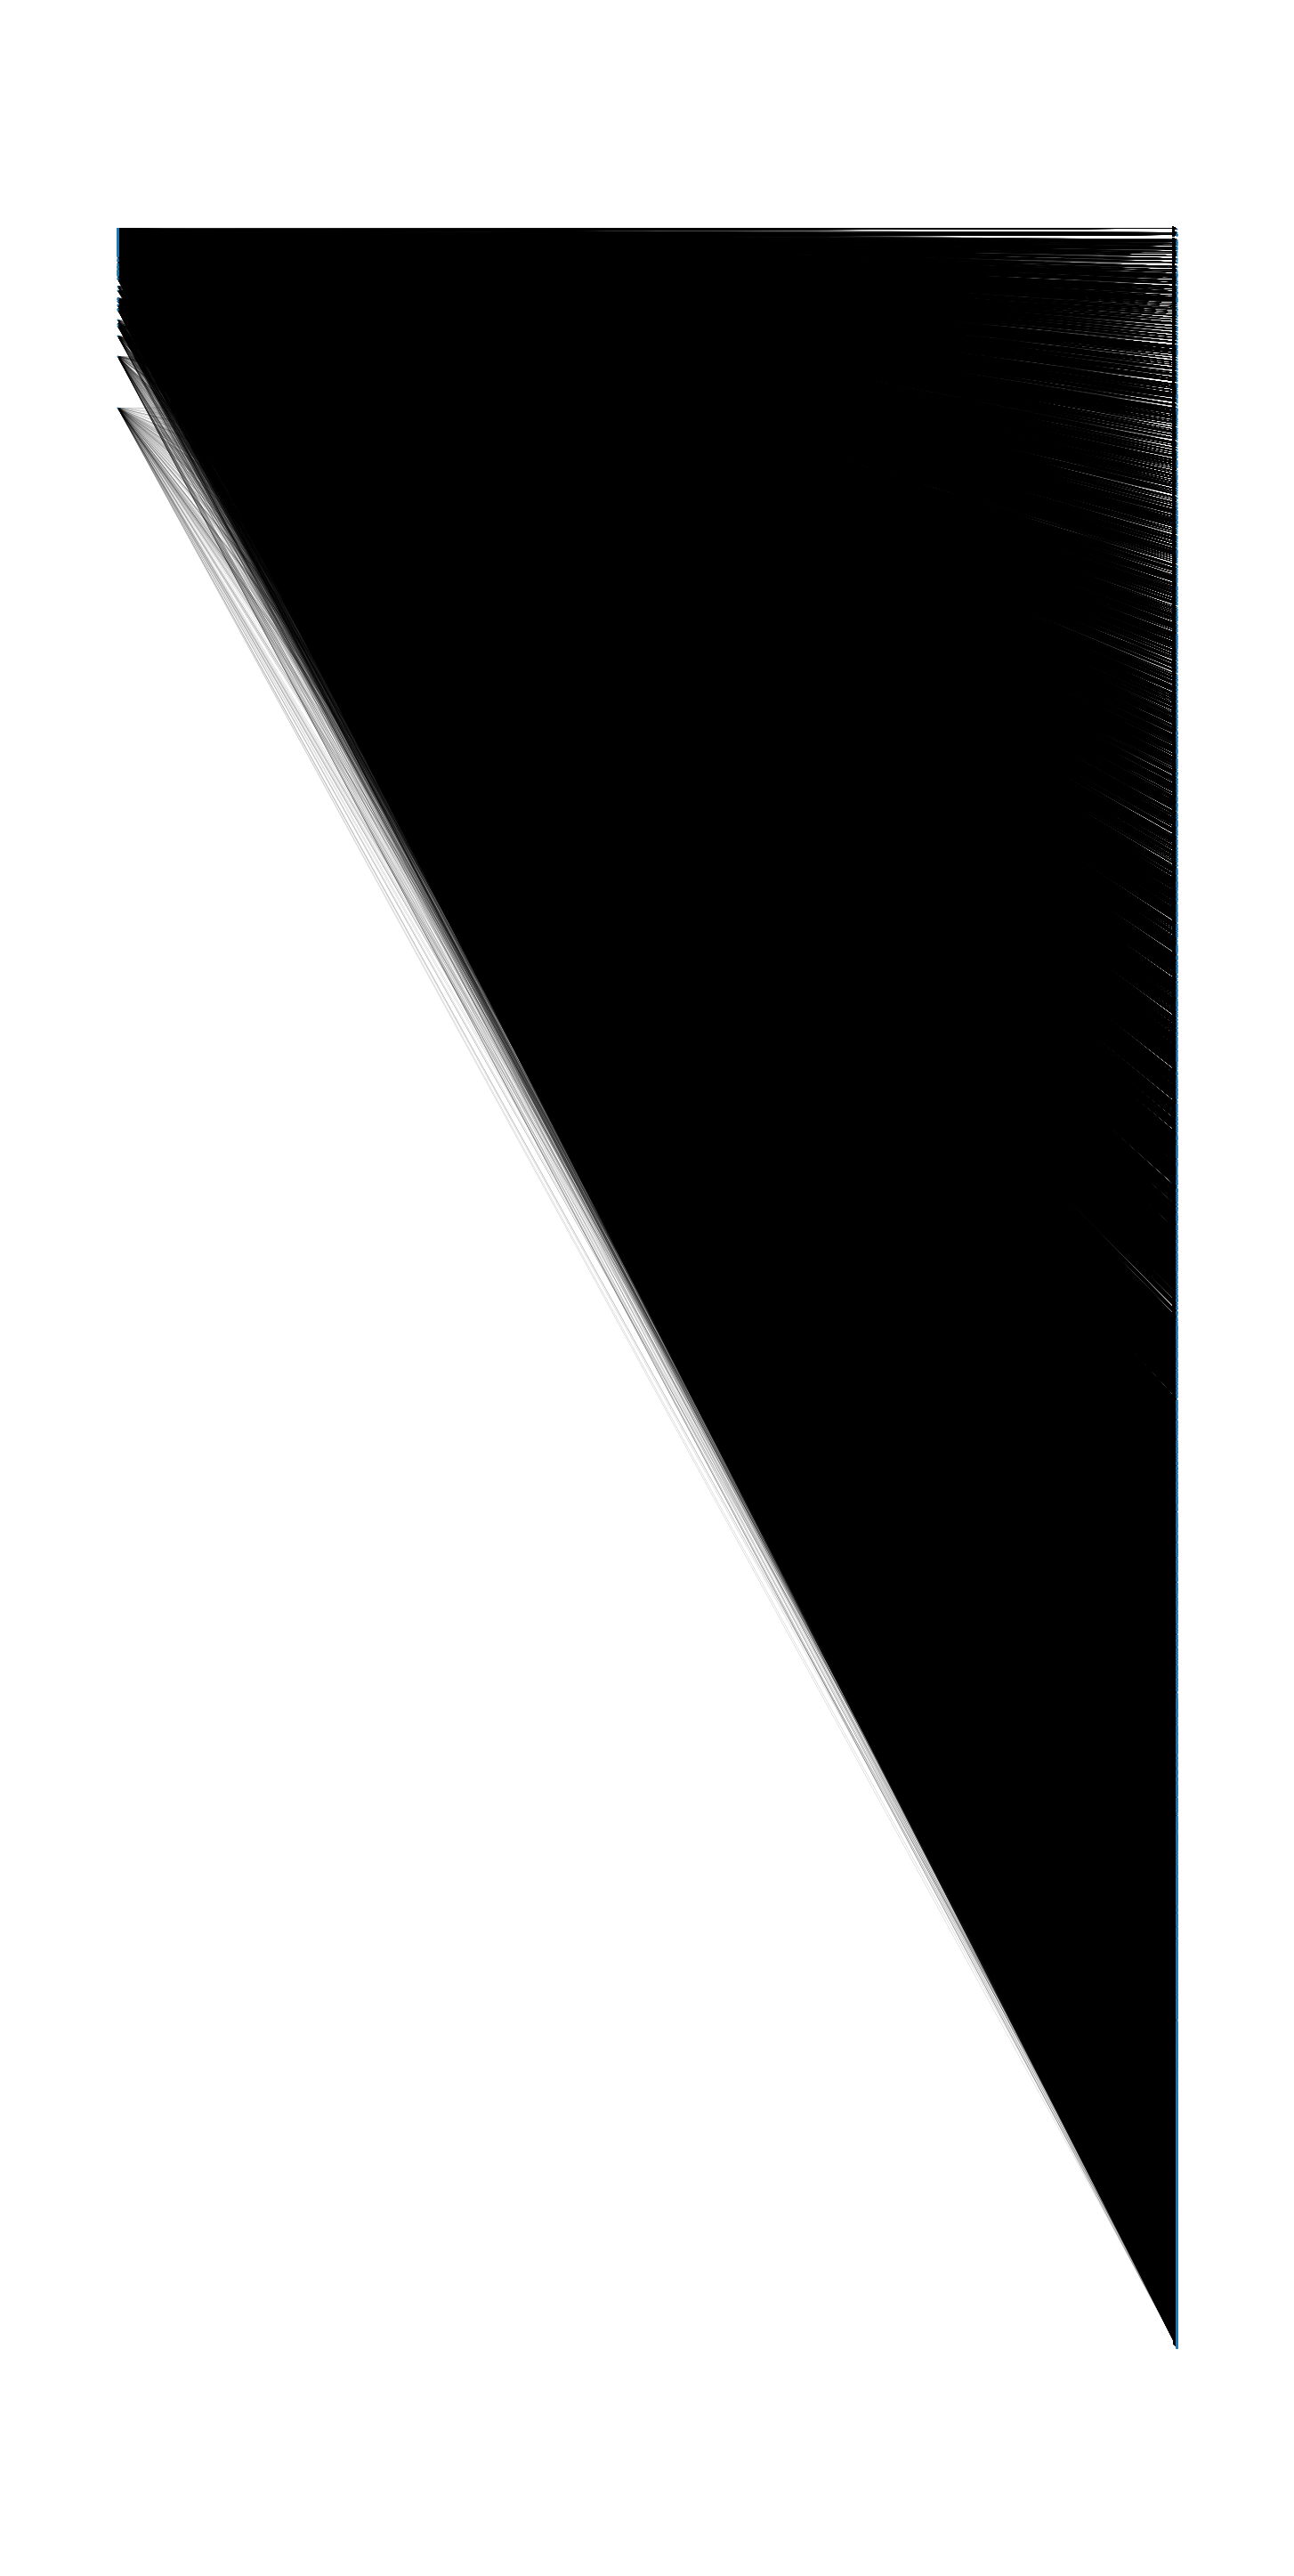

In [19]:
plt.figure(figsize=(20,40))
nx.draw(B1, pos, with_labels=False, node_size=1, width=0.1)
plt.show()

In [4]:
#save the list of users that forms the B1 network 
B1users=B1.out_degree()
users=[x for x in B1.nodes() if B1users[x]>=1]

# TEXT ANALYSIS part 1

## Read the corpus

In [32]:
#read corpus
corpus=pd.read_pickle("corpus.pkl")
corpus=corpus[0]

In [12]:
#take a look
corpus[0][:150]

"It's China's fault for the spread of the virus for eating pangolins and bats.Every country affected should boycott the 2022 Winter Olympic in Beijing."

# Open cleaned corpus and scores

In [3]:
#open clean
clean_read=pd.read_pickle('clean.pkl')

#open IDF dict
IDF_dict=pd.read_pickle('IDF_dict.pkl')
IDF_dict=dict(IDF_dict['count'])

#open TF dict
scores=pd.read_pickle('scores.pkl')
scores=dict(scores['count'])

In [27]:
#top n TF score words
ordered={k: v for k,v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
list(ordered)[:15]

['u',
 'trump',
 'virus',
 'people',
 'china',
 'get',
 'like',
 'coronavirus',
 'world',
 'one',
 'need',
 'time',
 'death',
 'know',
 'would']

In [38]:
#number of used words
print(f'words used {len([item for sublist in clean for item in sublist])}')

#number of unique words
print(f'unique words used {len(set([item for sublist in clean for item in sublist]))}')

words used 3044166
unique words used 123010


In [4]:
#transform clean into desidered format
clean=[]
for i in range(len(clean_read)):
    clean.append(list(clean_read.iloc[i][clean_read.iloc[i].notnull()]))

## Open cleaned corpus

In [4]:
cleaned_corpus=pd.read_pickle('cleaned_corpus.pkl')
cleaned_corpus=cleaned_corpus[0]

In [16]:
cleaned_corpus[0][:150]

'china fault spread virus eating pangolin bat every country affected boycott 2022 winter olympic beijing get virus treat give medical help let criminal'

In [44]:
#create tfifd matrix
vect = TfidfVectorizer(min_df=1, stop_words="english")
tfidf = vect.fit_transform(cleaned_corpus)
#compute pairwise similarity
pairwise_similarity = tfidf * tfidf.T

#get into a matrix
simmat=pairwise_similarity.A
#fill diagonal with 0
np.fill_diagonal(simmat, 0)

In [45]:
#look for most similar ones
most_similar=[]
for i in simmat:
    most_similar.append(np.argmax(i))
    
Counter(most_similar)

Counter({85: 2,
         13: 23,
         135: 2,
         24: 5,
         367: 7,
         44: 12,
         56: 1,
         376: 7,
         88: 9,
         98: 1,
         311: 72,
         535: 6,
         101: 6,
         280: 22,
         245: 4,
         188: 2,
         537: 11,
         392: 1,
         499: 2,
         58: 1,
         393: 39,
         59: 1,
         342: 22,
         228: 4,
         140: 5,
         201: 1,
         349: 3,
         94: 2,
         468: 1,
         388: 6,
         145: 1,
         291: 2,
         96: 2,
         281: 3,
         197: 1,
         282: 5,
         86: 2,
         67: 1,
         53: 1,
         26: 5,
         180: 1,
         476: 2,
         256: 2,
         481: 2,
         21: 5,
         552: 5,
         109: 6,
         3: 1,
         202: 3,
         453: 1,
         212: 2,
         455: 2,
         397: 2,
         164: 2,
         333: 3,
         115: 5,
         34: 2,
         87: 1,
         113: 4,
         2

In [46]:
feature_array = np.array(vect.get_feature_names())
tfidf_sorting = np.argsort(tfidf.toarray()).flatten()[::-1]
feature_names = vect.get_feature_names()

In [48]:
#select doc
doc = 311
feature_index = tfidf[doc,:].nonzero()[1]
#assign scores and select number of words to print
tfidf_scores = zip(feature_index, [tfidf[doc, x] for x in feature_index[:10]])
#print top n tfidf words and score
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print (f'{w, s}')

In [1]:
#print the summarized comments of user 311
# print(summarize(corpus[311], ratio=0.05))

#print its keywords
# print(keywords(corpus[311]))

In [11]:
####look for similarity over simple users with the user 311

#sample some comments at random 
rand_comm=comments.sample(n=3000, random_state=42)
#create their corpus
rand_corpus=[]
for comment in rand_comm.comment_text_original:
    temp=[]
    tok=nltk.RegexpTokenizer(r'\w+').tokenize(text=comment)
    for w in range(len(tok)):
        tok[w]=tok[w].lower()
        if tok[w] not in stopwords.words('english'):
            temp.append(WordNetLemmatizer().lemmatize(tok[w]))
    rand_corpus.append(temp)
    


In [13]:
#join the words back together
rand_clean=[]
for i in rand_corpus:
    rand_clean.append(' '.join(i))
    
#append as last line the user to compare to
rand_clean.append(cleaned_corpus[311])

In [18]:
vect = TfidfVectorizer(min_df=1, stop_words="english")
tfidf = vect.fit_transform(rand_clean)
#compute pairwise similarity
pairwise_similarity = tfidf * tfidf.T

#get into a matrix
simmat=pairwise_similarity.A
#fill diagonal with 0
np.fill_diagonal(simmat, 0)
    

In [37]:
#see the value of similarity with user 311 over the 90th percentile
np.percentile(simmat[-1], q=90)

0.10492332273501977

In [44]:
#select the comments with similarity over the 90th percentile
similarities=pd.DataFrame(simmat[-1])
found=similarities.loc[similarities[0]>np.percentile(simmat[-1], q=90)].index

In [76]:
# list(found)

In [68]:
#print the comments that are similar to the language of user 311
for idx in list(found):
    print(rand_comm.reset_index(drop=True).comment_text_original[idx])
    print('\n')

@Stanley Porter You are caught up in petty politics. Trump never instructed anyone to ingest household cleaners. The media took his statement out of context to fool individuals like yourself.          So then you are saying that you were totally cool with Trump up until he made the  cleaner joke?


More like the state charges 30%taxes on weed and they need that money mire than ever now..... In Murica it's all about the Benjamin's and fk the poor... The 3rd world reality America really is will be shown in full in about 3 weeks from now....


Oh God, someone take away Trumps cell phone, he is misspelling words again! 6:54


Imagine if the TV aired all the people that were dying of the flu the past 50 years!400 people died today in NY of the flu, back to you Bob.....


This is not about you trump


@David Markwald Careful, your right-wing hatred of women is showing.  Just think, come Nov. you and all your fellow trumpanzees can bark, howl and scream at the moon again like you did when the

Im scared because my parents said that 5 people died in America in where Im living so our school gave out masks to avoid being infected.


We need more people like this in government.


Pass this information on to all Republicans and Trump supporters: MAGA Hats are MADE IN CHINA and most likely infected with the Virus! <U+0001F609><U+0001F61C><U+2757>


Trump: Maybe you can . Maybe you can't . There is no way to hold him accountable . I said you can. I also said you can't. #Tragedy


Oh god the amount of racism there is in this comment section is surprisingly- let me get this straight: Although people say that Chinese eat exotic animals, its not all of the Chinese only some that dare to eat such things. It depends on the province as well- China has many provinces with different foods- and some of these foods do include exotic animals. Please dont blame all of the Chinese when it was the fault of improper handling of the food- and some people that ate it. Many of the people there ar

# Text analysis part 2

In [12]:
#we need to create a labeled dataset. let's query on the video with clear cospiracy theory in it
terms=['bioweapon', 'bill gates', '5g', 'qanon', 'hoax']

#create a list of URLs of videos containing the terms above
query_url=[]
for i in range(len(data)):
    if any(t in data.title[i].lower() for t in terms):
        query_url.append(data.video_id[i])

In [7]:
#build a training from a subset of 10000 from the original dataframe,
#then select the ones with the URL from the url list found above
train=comments.sample(n=10000, random_state=42).loc[comments.video_id.isin(query_url)]
train=train.reset_index(drop=True)
train['outcome']=np.zeros(len(train))

In [9]:
#manually read each comment and label if has conspiracy theories or not
for i in range(len(train)):
    print(train.comment_text_original[i])
    train.outcome[i]=int(input())

He's excited to try and help
0


C:\Users\giuli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hi Bill, these Corona - Viruses had their ORIGIN in the unhygienic animal markets in South- China CoV1 <U+0001F1E8><U+0001F1F3> and in the market of Wuhan CoV2. What would YOU advise the people in China <U+0001F1E8><U+0001F1F3> to prevent from a possible new worldwide spread of CoV3 and CoV4 in the future from these animal markets?
0
Don't trust bill
0
The dems are all on their knees hoping and praying this virus COVID19 gets worse and kills 1,000,000 People so they can put the blame on President Trump.Leave the planet you filthy lying democrats.Go to Mars and start your own ZOMBIE  RACE and call it the Damnocrats.
1
benny pitt, I dont understand your point, if you could clarify, that would be appreciated
0
This virus has shown our country (US) just how stupid and ignorant many of us are and some of us need to shut the hell up and allow the true leaders, lead and run the country.  Never put a chief idiot like Trump in office again.  We still have some of the greatest minds in the worl

0
Bill gate is creating Problem, wait for Reaction, and takeout the solution from under his sleeve, any one doubt Bill Gates not been vaccinated against the Coronavirus 19?   Watch the space. And wait for the bill gate chip to monitor and control you.
1
Based on his patents for his labs in wuhan  he maybe created this and now charging for the vaccine and chip that's why he's smiling he sees the lotto
1
You pay intellectuals to give you advice. A billionaire gives you free advice. Then you dismiss it and go about your business. Thats the intelectual capacity of modern man. We deserve what is coming.
0
<U+0414><U+0438><U+043C><U+0430> <U+0442><U+044B> <U+0443><U+0436><U+0435> <U+0437><U+0432><U+0435><U+0437><U+0434><U+0430> you tube! <U+041F><U+043E><U+0437><U+0434><U+0440><U+0430><U+0432><U+043B><U+044F><U+044E>!
0
I'm surprised he's not scared of the retards stopping vaccines.
0
Bill Gates, you knew. No one listened.
0
Damn this interview has made you more hot Trevor<U+0001F60D> love 

1
um...actually he does a lot for poor people of color in  India and Africa.https://www.gatesfoundation.org/Who-We-Are/General-Information/History
0
Beautiful!!!
0
If you think people in India and Africa are not capable of identifying a fraud, and stopping them, then you are a racist. In India, especially, they have thousands of highly competent bio-chemist and other related people, who watch him closely. There's no effin way he could get away any sort of hanky panky. People like you need to stop thinking countries other than Europe and the US are just poor little dumb people  who cant take care of themselves, especially, on these sort of things. per capita, African countries and India, have some of the LOWEST cases, by orders of magnitude!!
0
Bill Gates wants Nanobots in the Vaccine so we can all be tracked in numerous ways
1
Brian Williams is a very good newsman and Michael Moore really cares about his fellow American's. Trump doesn't! all he cares about is his ratings and thinks of 

0
Shafwan Ahmed No, Microsoft should hire this guy!
0
All this technology that has been hidden from the public could be taken advavtage of and we could expand outward to the galaxy where there is plenty of space for an finite amount of humans. Maybe if we vaccinate the filthy rich sociopaths that has decided to keep this hidden. With vaccines that are so full of heavy metal that they become brain damadged for life. Maybe we could overcome the problems of over population.
1
Bull gates is NOT the  guy we should be listening to about the engineered virus Covid-19.
1
Might get worse before it gets better with his ass!!
0
It's April fool's today... 100k to 240k bodies is not a joke... My heart goes out to everybody suffering from this and everybody bravely battling on the front lines. Your not promised tomorrow so make your today right. <U+270C><U+FE0F> And good luck
0
WAKE UP TO THE NEW WORLD ORDER!!!! Gates even said we will get 'vaccines' to EVERYONE IN THE WORLD. WAKE THE FUCK UP PEOPLE

In [155]:
#clean the train set 
train=pd.read_pickle('train.pkl')

#ADD THE NUMBER OF SUBSCRIBERS?????
#ADD POLARITY E SUBJECTIVITY!!!
train=pd.merge(train,data[['description', 'video_id', 'title']], on='video_id', how='left')
train=train.drop(['comment_text_display','comment_id','published_at','updatedt_at','video_id'], axis=1)
train=train.drop_duplicates()
train=train.reset_index(drop=True)

#clean the text in the description and comments of every line of train df
for i in range(len(train)):
    train.comment_text_original[i]=clean(train.comment_text_original[i])
    train.description[i]=clean(train.description[i])
    train.title[i]=clean(train.title[i])

train.head()

,user_channel_id,comment_text_original,like_count,outcome,description,title
0,UCGp_G2DrkzHFLtZZRSLKr1g,excited try help,3,0.0,bill gate co founder bill melinda gate foundat...,bill gate returning normal life april realistic
1,UCGp_G2DrkzHFLtZZRSLKr1g,excited try help,3,0.0,bill gate co founder bill melinda gate foundat...,bill gate make prediction coronavirus case peak
2,UCPh3urbjbdVDfU9yc5fkrNQ,hi bill corona virus origin unhygienic animal ...,0,0.0,trevor bill gate discus coronavirus testing ac...,bill gate fighting coronavirus daily social di...
3,UCm6fwElQRLSQVKi98VkTQBQ,trust bill,1,0.0,bill gate co founder bill melinda gate foundat...,bill gate returning normal life april realistic
4,UCm6fwElQRLSQVKi98VkTQBQ,trust bill,1,0.0,bill gate co founder bill melinda gate foundat...,bill gate make prediction coronavirus case peak


In [182]:
#create the test dataset using a different random sample
test=comments.sample(n=10000, random_state=1663887).loc[comments.video_id.isin(query_url)]
test=test.reset_index(drop=True)

#create manually the outcome vector to see the accuracy of the model
y=np.zeros(len(test))
for i in range(len(test)):
    print(test.comment_text_original[i])
    y[i]=int(input())

#add as column
test['outcome']=y

In [183]:
#clean as done with train
test=pd.merge(test,data[['description', 'video_id', 'title']], on='video_id', how='left')
test=test.drop(['comment_text_display','comment_id','published_at','updatedt_at','video_id'], axis=1)
test=test.drop_duplicates()
test=test.reset_index(drop=True)

#clean the text in the description and comments of every line of test df
for i in range(len(test)):
    test.comment_text_original[i]=clean(test.comment_text_original[i])
    test.description[i]=clean(test.description[i])
    test.title[i]=clean(test.title[i])

test.head()

,user_channel_id,comment_text_original,like_count,outcome,description,title
0,UCloO0m-R6UWpCbgnhGYOecA,bjarke rugsted meh depends,1,0.0,likeliest kill 10 million human being next 20 ...,bill gate afraid
1,UCMVtFonfcF1zZv3IVRMvw_A,coronavirus going expired april 16 actually ma...,0,1.0,bill gate co founder bill melinda gate foundat...,bill gate returning normal life april realistic
2,UCMVtFonfcF1zZv3IVRMvw_A,coronavirus going expired april 16 actually ma...,0,1.0,bill gate co founder bill melinda gate foundat...,bill gate make prediction coronavirus case peak
3,UCo1yMuGJB_QAiDFbOKhuEhw,ai fed information monsanto guaranteed ai find...,0,1.0,bill melinda gate foundation belief rapid adva...,bill gate saying ai save world full show
4,UCNAT2H4ZUnI4Q-bUeRGJveg,meatball man briefly mentioned one sentence di...,0,0.0,5g dangerous marque brownlee help u explain 5g...,truth 5g ft mkbhd


In [184]:
#merge them together and define the tfidf score colums
joined=pd.concat([train, test])
joined=joined.reset_index(drop=True)
joined=pd.concat([pd.DataFrame(vect.fit_transform(joined.comment_text_original).A),
           pd.DataFrame(vect.fit_transform(joined.description).A),
           pd.DataFrame(vect.fit_transform(joined.title).A),
           joined], axis=1)
joined=joined.drop(['user_channel_id', 'comment_text_original','description','title'], axis=1)

#save it so i don't have to redefine the output vector everytime
pd.to_pickle(joined, 'joined.pkl')

#read the saved one if needed
# joined=pd.read_pickle('joined.pkl')

joined.head()

,0,1,2,3,4,5,6,7,8,9,...,164,165,166,167,168,169,170,171,like_count,outcome
0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
1,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
2,0.0,0.0,0.32877,0.0,0.0,0.32877,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
4,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


In [186]:
#split into train and test
X_train=joined[:len(train)].drop('outcome', axis=1)
y_train=joined[:len(train)]['outcome']

X_test=joined[len(train):].drop('outcome', axis=1)
y_test=joined[len(train):]['outcome']

In [187]:
#search for the best parametrization with greed search
parameters={'C':[1,3,10],
           'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
           'gamma':('scale','auto'),
           'probability':[True, False],
           'decision_function_shape':('ovo','ovr')}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)
clf.best_params_

{'C': 3,
 'decision_function_shape': 'ovo',
 'gamma': 'scale',
 'kernel': 'linear',
 'probability': True}

In [204]:
#use the best parameters for the model, fit to train data and see precision
svc = SVC(C=3, decision_function_shape='ovo', gamma='scale', kernel='linear', probability=True)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.7159090909090909

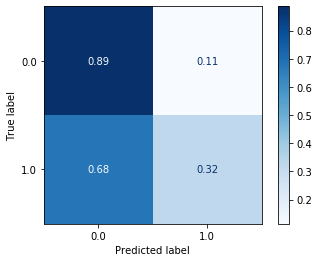

In [211]:
#see confusion matrix to see true positive and negative
plot_confusion_matrix(svc, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
plt.show()

add some info to the model to try to get an higher score on true positive

In [14]:
vect = TfidfVectorizer(min_df=1, stop_words="english")

train=pd.read_pickle('train.pkl')
train=pd.merge(train,data[['description', 'video_id', 'title']], on='video_id', how='left')
train=train.drop(['comment_text_display','comment_id','published_at','updatedt_at','video_id'], axis=1)
train=train.drop_duplicates()
train=train.reset_index(drop=True)

#add polarity and subjectivity
train['polarity']=np.zeros(len(train))
train['subjectivity']=np.zeros(len(train))
for i in range(len(train)):
    train.polarity[i]=TextBlob(train.comment_text_original[i]).sentiment.polarity
    train.subjectivity[i]=TextBlob(train.comment_text_original[i]).sentiment.subjectivity
    train.comment_text_original[i]=clean(train.comment_text_original[i])
    train.description[i]=clean(train.description[i])
    train.title[i]=clean(train.title[i])

#same for test set
test=comments.sample(n=10000, random_state=1663887).loc[comments.video_id.isin(query_url)]
test=test.reset_index(drop=True)
test['outcome']=y
test=pd.merge(test,data[['description', 'video_id', 'title']], on='video_id', how='left')
test=test.drop(['comment_text_display','comment_id','published_at','updatedt_at','video_id'], axis=1)
test=test.drop_duplicates()
test=test.reset_index(drop=True)

test['polarity']=np.zeros(len(test))
test['subjectivity']=np.zeros(len(test))
for i in range(len(test)):
    test.polarity[i]=TextBlob(test.comment_text_original[i]).sentiment.polarity
    test.subjectivity[i]=TextBlob(test.comment_text_original[i]).sentiment.subjectivity
    test.comment_text_original[i]=clean(test.comment_text_original[i])
    test.description[i]=clean(test.description[i])
    test.title[i]=clean(test.title[i])

#join
joined=pd.concat([train, test])
joined=joined.reset_index(drop=True)
joined=pd.concat([pd.DataFrame(vect.fit_transform(joined.comment_text_original).A),
           pd.DataFrame(vect.fit_transform(joined.description).A),
           pd.DataFrame(vect.fit_transform(joined.title).A),
           joined], axis=1)
joined=joined.drop(['user_channel_id', 'comment_text_original','description','title'], axis=1)

#split into train and test
X_train=joined[:len(train)].drop('outcome', axis=1)
y_train=joined[:len(train)]['outcome']

X_test=joined[len(train):].drop('outcome', axis=1)
y_test=joined[len(train):]['outcome']

## SVM

In [51]:
#search for the best parametrization with greed search
parameters={'C':[1,3,10],
           'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
           'gamma':('scale','auto'),
           'probability':[True, False],
           'decision_function_shape':('ovo','ovr')}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)
clf.best_params_

{'C': 1,
 'decision_function_shape': 'ovo',
 'gamma': 'scale',
 'kernel': 'linear',
 'probability': True}

In [228]:
#use the best parameters for the model, fit to train data and see precision
svc = SVC(C=3, decision_function_shape='ovo', gamma='scale', kernel='linear', probability=True)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.7045454545454546

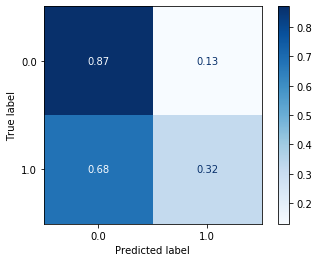

In [229]:
#see confusion matrix to see true positive and negative
plot_confusion_matrix(svc, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
plt.show()

might be overfitted. now let's try other classifiers

## NN

In [233]:
parameters={'alpha':[0.0001,0.0003,0.001],
           'activation':('identity', 'logistic', 'tanh', 'relu'),
           'solver':('lbfgs','sgd','adam'),
           'shuffle':[True, False],
           'learning_rate':('constant','invscaling','adaptive'),
           'max_iter':[500],
           }

mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters)
clf.fit(X_train, y_train)
clf.best_params_

{'activation': 'logistic',
 'alpha': 0.001,
 'learning_rate': 'invscaling',
 'max_iter': 500,
 'shuffle': True,
 'solver': 'lbfgs'}

In [234]:
#use the best parameters for the model, fit to train data and see precision
mlp = MLPClassifier(activation='logistic', alpha=0.001, learning_rate='invscaling', max_iter=500, shuffle=True, solver='lbfgs')
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

0.6931818181818182

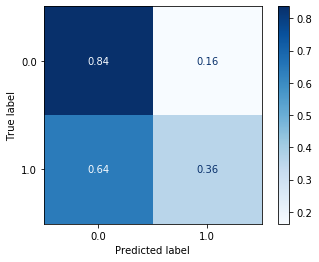

In [235]:
#see confusion matrix to see true positive and negative
plot_confusion_matrix(mlp, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
plt.show()

## Naive bayes

In [16]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.5170454545454546

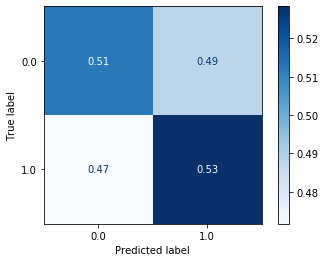

In [17]:
plot_confusion_matrix(nb, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
plt.show()

## BALANCING THE DATA

In [29]:
#let's balance the dataset and try again with the same classifiers
X_train['outcome']=y_train
XtrainBal=X_train[X_train.outcome==1].sample(n=50, random_state=42)
XtrainBal=pd.concat([XtrainBal, X_train[X_train.outcome==0].sample(n=50, random_state=42)])
ytrainBal=XtrainBal.outcome
XtrainBal=XtrainBal.drop('outcome', axis=1)

balanced SVM

In [30]:
#search for the best parametrization with greed search
parameters={'C':[1,3,10],
           'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
           'gamma':('scale','auto'),
           'probability':[True, False],
           'decision_function_shape':('ovo','ovr')}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(XtrainBal, ytrainBal)
clf.best_params_

{'C': 3,
 'decision_function_shape': 'ovo',
 'gamma': 'scale',
 'kernel': 'linear',
 'probability': True}

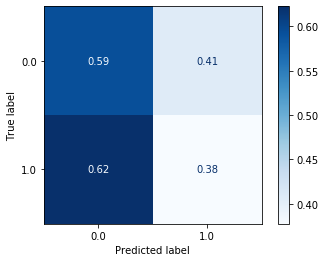

0.5284090909090909

In [38]:
svc = SVC(C=3, decision_function_shape='ovo', gamma='scale', kernel='linear', probability=True)
svc.fit(XtrainBal, ytrainBal)

plot_confusion_matrix(svc, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
plt.show()

svc.score(X_test, y_test)

balanced NN

In [41]:
parameters={'alpha':[0.0001,0.0003,0.001],
           'activation':('identity', 'logistic', 'tanh', 'relu'),
           'solver':('lbfgs','sgd','adam'),
           'shuffle':[True, False],
           'learning_rate':('constant','invscaling','adaptive'),
           'max_iter':[500],
           }

mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters)
clf.fit(XtrainBal, ytrainBal)
clf.best_params_

{'activation': 'identity',
 'alpha': 0.001,
 'learning_rate': 'constant',
 'max_iter': 500,
 'shuffle': False,
 'solver': 'adam'}

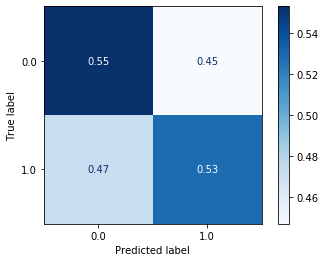

0.5454545454545454

In [43]:
#use the best parameters for the model, fit to train data and see precision
mlp = MLPClassifier(activation='identity', alpha=0.001, learning_rate='constant', max_iter=500, shuffle=True, solver='adam')
mlp.fit(XtrainBal, ytrainBal)

plot_confusion_matrix(mlp, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
plt.show()

mlp.score(X_test, y_test)

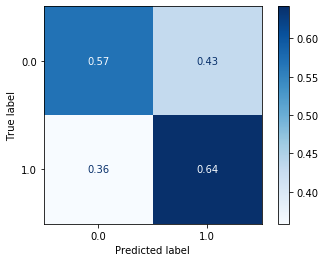

0.5909090909090909

In [47]:
nb = GaussianNB()
nb.fit(XtrainBal, ytrainBal)
plot_confusion_matrix(nb, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
plt.show()
nb.score(X_test, y_test)

## Cross validation

In [122]:
X=joined.drop('outcome', axis=1)
y=joined.outcome

parameters={'C':[1,3,10],
           'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
           'gamma':('scale','auto'),
           'probability':[True, False],
           'decision_function_shape':('ovo','ovr')}
svc = SVC()
clf = GridSearchCV(svc, parameters)

kf=KFold(random_state=42)

for train_index, test_index in kf.split(X):
    #create 5 different partition for the train and test set
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #run the greed search to find the best parameters
    clf.fit(X_train, y_train)
    #use them in the svm model
    svc=SVC(**clf.best_params_)
    #fit to the test data
    svc.fit(X_train, y_train)
    #plot confusion matrix and print accuracy
    plot_confusion_matrix(svc, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
    plt.show()

    print(svc.score(X_test, y_test))

KeyboardInterrupt: 

In [139]:
joined.loc[joined.outcome==1]
joinedBal=joined.loc[joined.outcome==1].sample(n=100, random_state=666)
joinedBal=pd.concat([joinedBal,
                     joined.loc[joined.outcome==0].sample(n=100, random_state=666)])
#rearrange at random
joinedBal=joinedBal.sample(frac=1)
joinedBal=joinedBal.reset_index(drop=True)

### BALANCED CROSS VALIDATED SVM

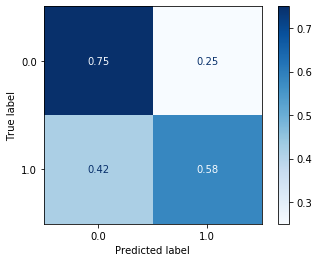

0.65


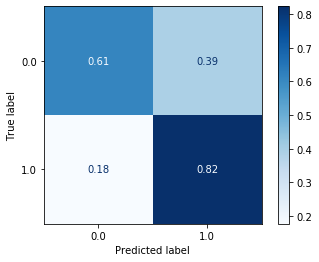

0.7


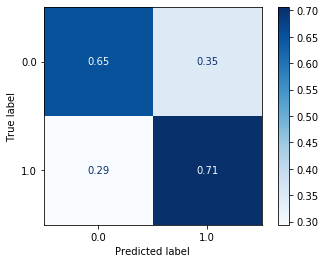

0.675


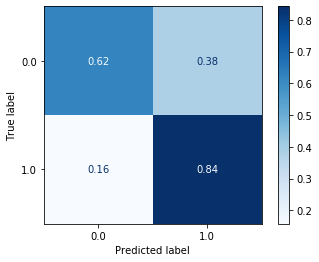

0.725


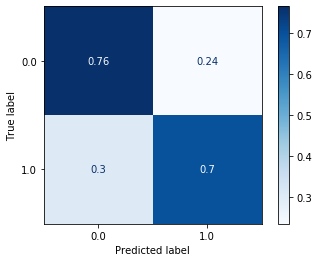

0.725


In [140]:
X=joinedBal.drop('outcome', axis=1)
y=joinedBal.outcome

parameters={'C':[1,3,10],
           'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
           'gamma':('scale','auto'),
           'probability':[True, False],
           'decision_function_shape':('ovo','ovr')}
svc = SVC()
clf = GridSearchCV(svc, parameters)

kf=KFold(random_state=42)

for train_index, test_index in kf.split(X):
    #create 5 different partition for the train and test set
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #run the greed search to find the best parameters
    clf.fit(X_train, y_train)
    #use them in the svm model
    svc=SVC(**clf.best_params_)
    #fit to the test data
    svc.fit(X_train, y_train)
    #plot confusion matrix and print accuracy
    plot_confusion_matrix(svc, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
    plt.show()

    print(svc.score(X_test, y_test))

### BALANCED CROSS VALIDATED NN

In [ ]:
parameters={'alpha':[0.0001,0.0003,0.001],
           'activation':('identity', 'logistic', 'tanh', 'relu'),
           'solver':('lbfgs','sgd','adam'),
           'shuffle':[True, False],
           'learning_rate':('constant','invscaling','adaptive'),
           'max_iter':[500],
           }
mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters)
kf=KFold(random_state=42)

for train_index, test_index in kf.split(X):
    #create 5 different partition for the train and test set
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #run the greed search to find the best parameters
    clf.fit(X_train, y_train)
    #use them in the svm model
    mlp=MLPClassifier(**clf.best_params_)
    #fit to the test data
    mlp.fit(X_train, y_train)
    #plot confusion matrix and print accuracy
    plot_confusion_matrix(mlp, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
    plt.show()

    print(svc.score(X_test, y_test))

### BALANCED CROSS VALIDATED BAYES

In [ ]:
nb = GaussianNB()
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    nb.fit(X_train, y_train)
    plot_confusion_matrix(nb, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
    plt.show()
    print(svc.score(X_test, y_test))

In [238]:
train

,user_channel_id,comment_text_original,like_count,outcome,description,title,polarity,subjectivity
0,UCGp_G2DrkzHFLtZZRSLKr1g,excited try help,3,0.0,bill gate co founder bill melinda gate foundat...,bill gate returning normal life april realistic,0.375000,0.750000
1,UCGp_G2DrkzHFLtZZRSLKr1g,excited try help,3,0.0,bill gate co founder bill melinda gate foundat...,bill gate make prediction coronavirus case peak,0.375000,0.750000
2,UCPh3urbjbdVDfU9yc5fkrNQ,hi bill corona virus origin unhygienic animal ...,0,0.0,trevor bill gate discus coronavirus testing ac...,bill gate fighting coronavirus daily social di...,0.045455,0.526515
3,UCm6fwElQRLSQVKi98VkTQBQ,trust bill,1,0.0,bill gate co founder bill melinda gate foundat...,bill gate returning normal life april realistic,0.000000,0.000000
4,UCm6fwElQRLSQVKi98VkTQBQ,trust bill,1,0.0,bill gate co founder bill melinda gate foundat...,bill gate make prediction coronavirus case peak,0.000000,0.000000
...,...,...,...,...,...,...,...,...
178,UCqkbKpvSez4IeL70HmIf4ZA,wake new world order gate even said get vaccin...,1,1.0,bill gate co founder bill melinda gate foundat...,bill gate make prediction coronavirus case peak,-0.333540,0.527273
179,UCnhyrvXHK57qXmnZDHqDiLw,bill snake,0,0.0,massive coronavirus outbreak raised question c...,see bill gate chilling pandemic warning trump ...,0.000000,0.000000
180,UCfUoOnrN4ENFVabcDz1hL5w,u 042d u 0442 u 043e u 0420 u 043e u 0441 u 04...,0,0.0,u 041e u 0442 u 043f u 0440 u 0430 u 0432 u 04...,u 041a u 0430 u 043a u 0440 u 0430 u 0431 u 04...,0.000000,0.000000
181,UC__l-u8KW8VcXPTBFcieHMQ,bill gate foundation longer welcome africa ind...,0,1.0,bill gate gave ted talk global pandemic prepar...,bill gate global innovation key achieving retu...,0.800000,0.900000


In [5]:
y=np.array([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0.])

In [8]:
data=pd.read_csv('statistiche.csv', encoding = "ISO-8859-1")
data=data.drop(['Unnamed: 0', 'favorite_count'], axis=1)
data.head()

,video_id,title,description,publishedAt,channelId,view_count,like_count,dislike_count,comment_count
0,N4WKdZjnU2s,Cases in coronavirus pandemic surge in US,The number of cases in the U.S. soared to more...,2020-03-22,UCBi2mrWuNuyYy4gbM6fU18Q,3647509.0,22104.0,3292.0,14898.0
1,5z5cLsZI6Mk,Lawmakers react to failed procedural vote on c...,Congress failed on March 22 to pass a procedur...,2020-03-23,UCHd62-u_v4DvJ8TCFtpi4GA,105110.0,911.0,308.0,1939.0
2,beYlKvGOxqI,Coronavirus: The global response to another hu...,Around the world governments are battling to k...,2020-03-21,UC16niRr50-MSBwiO3YDb3RA,935806.0,5684.0,480.0,2147.0
3,9soBsFM3rAI,Coronavirus Latest world wide updates - Live u...,Coronavirus - Latest data and updates. Providi...,2020-03-18,UClOfk9gsvf5dKLZXuctxTNA,6336145.0,22319.0,1916.0,0.0
4,sowFQ7RFBjw,Italia: el coronavirus no cede y se cobró 793 ...,Coronavirus: la situación en Italia no mejora ...,2020-03-22,UCqmZBc7T8J5TFuRT5uf-j_g,330454.0,1482.0,152.0,425.0


In [28]:
data.isna().sum()

video_id            0
title               0
description       211
publishedAt         0
channelId           0
view_count          0
like_count        507
dislike_count     507
comment_count    1629
dtype: int64

In [65]:
#drop lines without view count
data=data.loc[data.view_count.notnull()]
#drop all lines with comments =NA
data=data.loc[data.comment_count.notnull()]
#drop all lines from LIVE videos
data=data.loc[~data.title.str.contains('LIVE')] 
#log-transform the variables
# data['log_comm']=np.log(data.comment_count)
# data['log_view']=np.log(data.view_count)
#
data=data.loc[data.comment_count!=0]
data=data.loc[data.view_count!=data.view_count.max()]

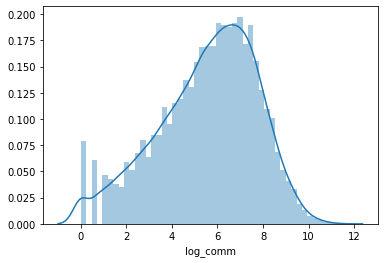

In [51]:
sns.distplot(data.log_comm)
plt.show()

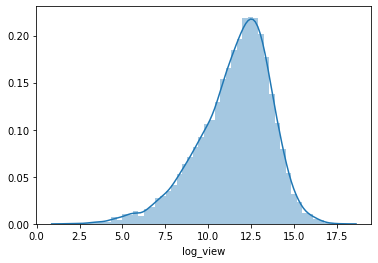

In [52]:
sns.distplot(data.log_view)
plt.show()

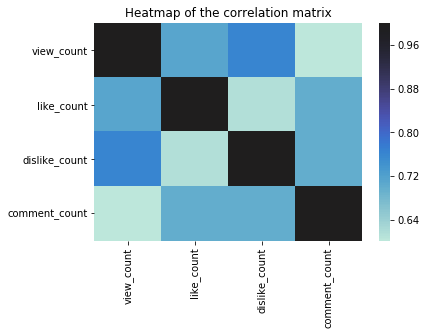

In [68]:
# numerical=data.iloc[:,5:]
sns.heatmap(data.corr(), center=1)
plt.title('Heatmap of the correlation matrix')
plt.show()

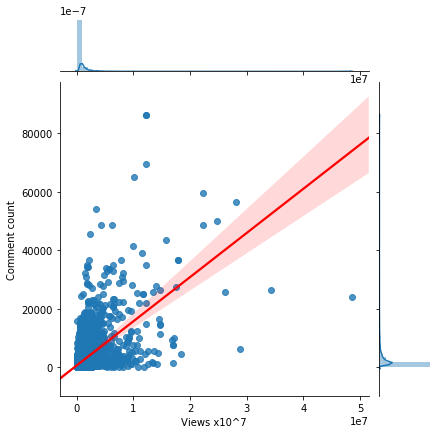

In [62]:
#cancellare tutti i video con 0 commenti (possono essere stati disattivati i commenti)
# data=data.loc[data.comment_count!=0]

#plot scatter
sns.jointplot(x="view_count", y="comment_count", data=data, kind='reg', 
              joint_kws={'line_kws':{'color':'red'}})
# plt.title('Views VS Comments count')
plt.xlabel('Views x10^7')
plt.ylabel('Comment count')
plt.show()

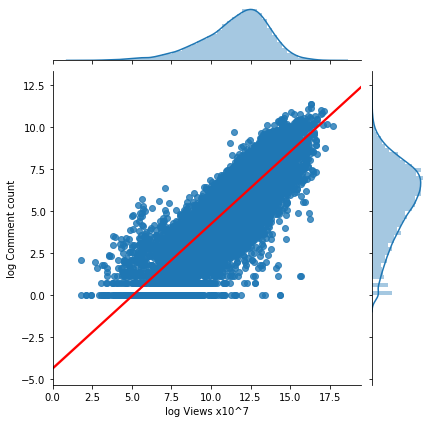

In [63]:
#cancellare tutti i video con 0 commenti (possono essere stati disattivati i commenti)

#plot scatter
sns.jointplot(x="log_view", y="log_comm", data=data, kind='reg', 
              joint_kws={'line_kws':{'color':'red'}})
# plt.title('Views VS Comments count')
plt.xlabel('log Views x10^7')
plt.ylabel('log Comment count')
plt.show()

In [56]:
stats.spearmanr(data.view_count, data.comment_count)

SpearmanrResult(correlation=0.8428955791836991, pvalue=0.0)

In [57]:
stats.kendalltau(data.view_count, data.comment_count)

KendalltauResult(correlation=0.6569940814192027, pvalue=0.0)

In [58]:
stats.pearsonr(data.view_count, data.comment_count)

(0.6021735737543056, 0.0)

In [61]:
stats.pearsonr(data.log_comm, data.log_view)

(0.8397624789596314, 0.0)